In [13]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd

In [14]:
T = 0.1
s = ctl.TransferFunction.s

In [15]:
C = 0.394784176043574/(1.0*s**2 + 0.888576587631673*s + 0.394784176043574)
C

TransferFunction(array([0.39478418]), array([1.        , 0.88857659, 0.39478418]))

In [16]:
C_z = ctl.c2d(C, T, method='zoh')
C_z

TransferFunction(array([0.0019161 , 0.00186018]), array([ 1.        , -1.91119952,  0.9149758 ]), 0.1)

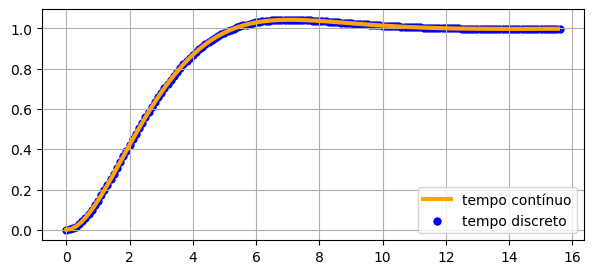

In [17]:
plt.figure(figsize=(7, 3))

time, response = ctl.step_response(C)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

time, response = ctl.step_response(C_z)
plt.scatter(time, response, color='blue', s=25, label='tempo discreto')

plt.grid()
plt.legend()
plt.show()

# COMPARANDO A RESPOSTA DO CONTROLADOR

In [18]:
num, den = ctl.tfdata(C_z)
num = np.squeeze(num)
den = np.squeeze(den)

num = num/den[0]
den = den/den[0]

print(num)
print(den)

[0.0019161  0.00186018]
[ 1.         -1.91119952  0.9149758 ]


In [19]:
if type(num) == np.float64:
    num = np.array([num])

In [20]:
def getDigitalFunction(num, den):
    out = ''

    for i in range(0, len(num)):
        out += f'{num[i]}*X_n{i} + '

    for i in range(1, len(den)):
        out += f'+ {-1*den[i]}*Y_n{i}'

    return out.replace('X_n0', 'X_n').replace('+ +', '+').replace('+ -', '-')


out = getDigitalFunction(num, den)
print(out + ';')

0.0019161041937802992*X_n + 0.0018601789148163794*X_n1 + 1.9111995199846048*Y_n1-0.9149758030932013*Y_n2;


In [21]:
Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

def computeController(X_n):
    global Y_n1, Y_n2, Y_n3
    global X_n1, X_n2, X_n3
    Y_n = eval(out)

    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n
    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n

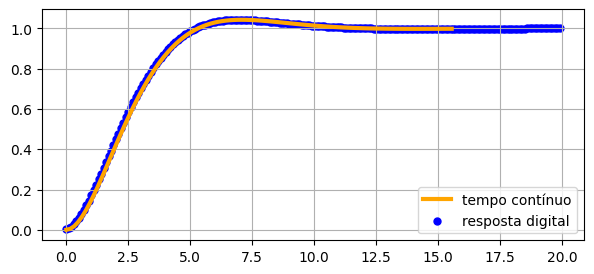

In [22]:
plt.figure(figsize=(7, 3))

time, response = ctl.step_response(C)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

Y_n1 = Y_n2 = 0
X_n1 = X_n2 = 0
time     = np.arange(0, 20, T)
response = [computeController(1) for i in time] 
plt.scatter(time, response, color='blue', s=25, label='resposta digital')

plt.grid()
plt.legend()
plt.show()

# TESTANDO NOS DADOS DISCRETOS

In [23]:
def normalizeData(time, response, T=0.01):
    timeIntervals = np.arange(np.min(time), np.max(time), T)
    xData = []
    yData = []

    for i in range(len(timeIntervals) - 1):
        position      = timeIntervals[i]
        next_position = timeIntervals[i + 1]

        target = response[(time > position) & (time <= next_position)]
        
        if len(target) == 0:
            continue
        
        t = (next_position + position)/2
        y = np.min(target)

        xData.append(t)
        yData.append(y)

    return xData, yData

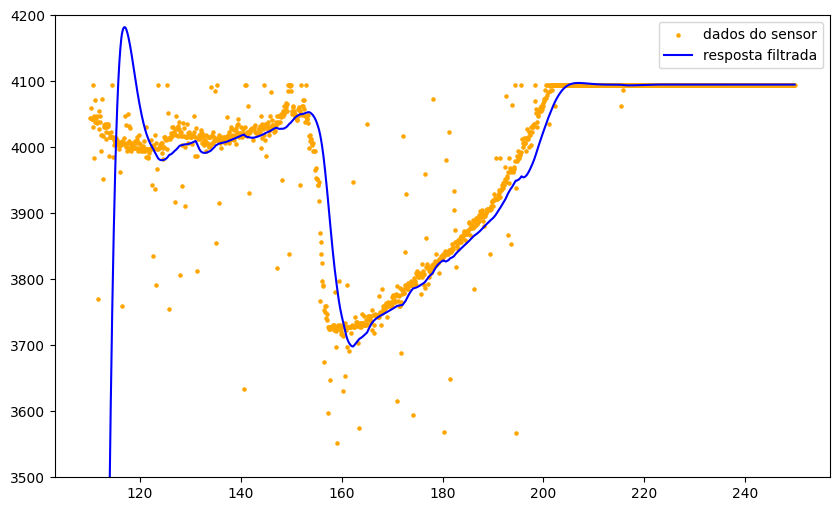

In [24]:
df = pd.read_csv('DataBase.csv')
df = df.loc[(df['time'] > 110) & (df['time'] < 250)]

xData = df['time'].to_numpy()
yData = df['analog'].to_numpy()

xData, yData = normalizeData(xData, yData, T=0.1)
plt.figure(figsize=(10, 6))
plt.scatter(xData, yData, s=5, color='orange', label='dados do sensor')

Y_n1 = Y_n2 = 0
X_n1 = X_n2 = 0
response = [computeController(val) for val in yData] 
plt.plot(xData, response, color='blue', label='resposta filtrada')
plt.ylim(3500, 4200)
plt.legend()
plt.show()